In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [2]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [3]:
S0 = 1
K1 = 0.9
K2 = 0.95
K3 = 1.05
K4 = 1.1
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 100

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [4]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

In [5]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = my_input + [premium] + [hedge_cost] + [price]

for j in range(N):
#   Jupyter Notebook으로 leaky relu를 실행할 경우  'unknown activation_function: LeakyReLU' 오류 발생
#   따라서 교수님이 알려준 코드에서 동일한 결과가 나오도록 약간 변경하였습니다.
    delta = tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])
    #info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price


payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x-K1,0)-tf.math.maximum(x-K2,0)-tf.math.maximum(x-K3,0)+tf.math.maximum(x-K4,0), name='payoff')(price)
cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name="cum_cost-premium")([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

In [6]:
premium = (bscall(S0,K1,T,r,sig)-bscall(S0,K2,T,r,sig)-bscall(S0,K3,T,r,sig)+bscall(S0,K4,T,r,sig)) * np.ones([M,1])
cost = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [premium]+[cost]+[SS]
y = np.zeros([M,1])

In [7]:
model.compile(loss='mse', optimizer='adam')

In [8]:
hist = model.fit(x,y, batch_size=32, epochs=100, verbose=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 7s 288ms/step - loss: 7.7778e-04 - val_loss: 2.8965e-04
Epoch 2/100
25/25 [==============================] - 1s 21ms/step - loss: 3.1410e-04 - val_loss: 2.9059e-04
Epoch 3/100
25/25 [==============================] - 1s 21ms/step - loss: 1.8811e-04 - val_loss: 2.7995e-04
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 1.4106e-04 - val_loss: 2.8252e-04
Epoch 5/100
25/25 [==============================] - 1s 22ms/step - loss: 1.2549e-04 - val_loss: 2.6946e-04
Epoch 6/100
25/25 [==============================] - 1s 24ms/step - loss: 9.9882e-05 - val_loss: 2.7202e-04
Epoch 7/100
25/25 [==============================] - 1s 23ms/step - loss: 1.0595e-04 - val_loss: 2.7502e-04
Epoch 8/100
25/25 [==============================] - 1s 25ms/step - loss: 9.7408e-05 - val_loss: 2.7381e-04
Epoch 9/100
25/25 [==============================] - 1s 23ms/step - loss: 8.1847e-05 - val_loss: 2.6657e-04
Epoch 10/100
25/25 [=======

Epoch 76/100
25/25 [==============================] - 1s 22ms/step - loss: 4.9548e-05 - val_loss: 2.4065e-04
Epoch 77/100
25/25 [==============================] - 1s 22ms/step - loss: 5.3358e-05 - val_loss: 1.9927e-04
Epoch 78/100
25/25 [==============================] - 1s 22ms/step - loss: 5.9932e-05 - val_loss: 2.7370e-04
Epoch 79/100
25/25 [==============================] - 1s 22ms/step - loss: 5.0262e-05 - val_loss: 2.4339e-04
Epoch 80/100
25/25 [==============================] - 1s 22ms/step - loss: 5.5319e-05 - val_loss: 3.5099e-04
Epoch 81/100
25/25 [==============================] - 1s 22ms/step - loss: 6.6411e-05 - val_loss: 2.5264e-04
Epoch 82/100
25/25 [==============================] - 1s 22ms/step - loss: 6.3766e-05 - val_loss: 2.9142e-04
Epoch 83/100
25/25 [==============================] - 1s 22ms/step - loss: 6.0527e-05 - val_loss: 2.7574e-04
Epoch 84/100
25/25 [==============================] - 1s 21ms/step - loss: 6.1748e-05 - val_loss: 2.8966e-04
Epoch 85/100
25/25 

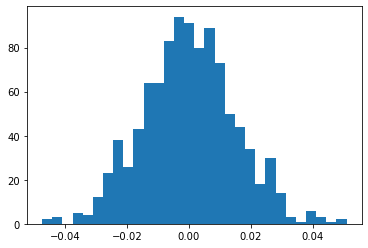

In [9]:
plt.hist(model.predict(x), bins=30)
plt.show()

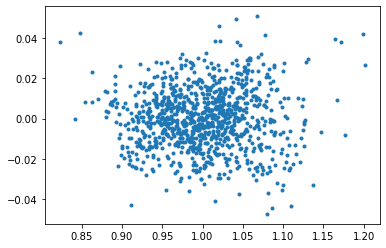

In [10]:
plt.plot(S[:,-1], model.predict(x), marker = ".", linestyle='none')
plt.show()